In [ ]:
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (MinMaxScaler,StandardScaler)
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer

In [ ]:
df_august = pd.read_csv('https://raw.githubusercontent.com/WitoldSurdej/PFML/master/apartments_pl_2023_08.csv')
df_september = pd.read_csv('https://raw.githubusercontent.com/WitoldSurdej/PFML/master/apartments_pl_2023_09.csv')
df_october = pd.read_csv('https://raw.githubusercontent.com/WitoldSurdej/PFML/master/apartments_pl_2023_10.csv')

In [ ]:
df_august['Month'] = 0
df_september['Month'] = 1
df_october['Month'] = 2

In [ ]:
frames = [df_august, df_september, df_october]
df = pd.concat(frames)

In [ ]:
# Shape of dataframe
df.shape

(52592, 29)

Saving 1/3 of original data for future

In [ ]:
df_live, df_backup = train_test_split(df,test_size=0.3, random_state=42)
print(f'df_live.shape = {df_live.shape}')
print(f'df_backup.shape = {df_backup.shape}')

df_live.shape = (36814, 29)
df_backup.shape = (15778, 29)


Hierarchy of features:  1) squareMeters  2) Longitude  3) poiCount  4) rooms    5) centreDistance  6)clinicDistance  7) kindergardenDistance


Here is where we could do more data processing on df_live like selecting only numerical columns. If we wanted to look for missing values or repetitions then it's better to do it on Xn

In [ ]:
num_cols = df_live.select_dtypes([np.number]).columns

df_nums = df_live[num_cols].reset_index(drop=True)

# Dropping rows which contain missing values
df_clean = df_nums.dropna()
print(f'df_nums.shape = {df_nums.shape}')

df_nums.shape = (36814, 18)


In [ ]:
X = df_clean.loc[:,df_nums.columns != 'price']
y = df_clean['price'].values

print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')

X.shape = (24156, 17)
y.shape = (24156,)


In [ ]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

print(type(X_normalized))
print(type(X_normalized_df))
print(type(X))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
selected_columns_2 = ['squareMeters', 'longitude']
selected_columns_3 = ['squareMeters', 'longitude', 'poiCount']
selected_columns_5 = ['squareMeters', 'longitude', 'poiCount', 'rooms', 'centreDistance']
selected_columns_7 = ['squareMeters', 'longitude', 'poiCount', 'rooms', 'centreDistance', 'clinicDistance', 'kindergartenDistance']

X2=X_normalized_df[selected_columns_2]
X3=X_normalized_df[selected_columns_3]
X5=X_normalized_df[selected_columns_5]
X7=X_normalized_df[selected_columns_7]

print(f'X2.shape = {X2.shape}')
print(f'X3.shape = {X3.shape}')
print(f'X5.shape = {X5.shape}')
print(f'X7.shape = {X7.shape}')

X2.shape = (24156, 2)
X3.shape = (24156, 3)
X5.shape = (24156, 5)
X7.shape = (24156, 7)


1- Decision Trees for 2 features

In [ ]:
# Splitting the Dataset for 2 features
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape = {X_test.shape}')

X_train.shape = (19324, 2)
X_test.shape = (4832, 2)


Defining the 2 feature Decision Tree*

In [ ]:
# Function for calculating RMSE
def rmse(y_true, y_pred):
    rm = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rm
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
# Make a scorer from the RMSE function
rmse_scorer = (make_scorer(rmse, greater_is_better=False))

model = DecisionTreeRegressor() #to create the DT model

# Hyperparameter tuning
gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 25),
                                'min_samples_split': range(5, 50, 5)},
                  cv=kfold,
                  n_jobs=1,
                  scoring=rmse_scorer)

gs.fit(X_train, y_train)

# Displaying the best depth
print(gs.best_params_)
# Diplaying the RMSE of the best depth
print(-gs.best_score_)
Optimal_2 = gs.best_params_['max_depth']
rmse_2 = -gs.best_score_

{'max_depth': 24, 'min_samples_split': 5}
162116.0639340539


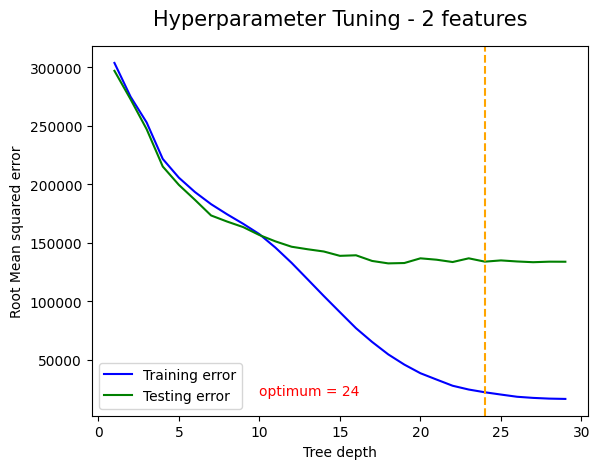

In [ ]:
max_depths = range(1, 30)

training_error = []
for max_depth in max_depths:
    f2_model_1 = DecisionTreeRegressor(max_depth=max_depth)
    f2_model_1.fit(X2, y)
    training_error.append(sqrt(mse(y, f2_model_1.predict(X2))))

testing_error = []
for max_depth in max_depths:
    f2_model_2 = DecisionTreeRegressor(max_depth=max_depth)
    f2_model_2.fit(X_train, y_train)
    testing_error.append(sqrt(mse(y_test, f2_model_2.predict(X_test))))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')
plt.axvline(x=Optimal_2, color='orange', linestyle='--')
plt.annotate('optimum = {}'.format(Optimal_2), xy=(10, 20000), color='red')
plt.ylabel('Root Mean squared error')
plt.title('Hyperparameter Tuning - 2 features', pad=15, size=15)
plt.legend()
plt.savefig('error2.png')

2- Decision Trees for 3 features

*Defining the 3 feature Decision Tree*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size = 0.2, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape = {X_test.shape}')

X_train.shape = (19324, 3)
X_test.shape = (4832, 3)


In [ ]:
def rmse(y_true, y_pred):
    rm = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rm
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
# Make a scorer from the RMSE function
rmse_scorer = (make_scorer(rmse, greater_is_better=False))

model = DecisionTreeRegressor()

gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 25),
                                'min_samples_split': range(5, 50, 5)},
                  cv=kfold,
                  n_jobs=1,
                  scoring=rmse_scorer)

gs.fit(X_train, y_train)

print(gs.best_params_)
print(-gs.best_score_)
Optimal_3 = gs.best_params_['max_depth']
rmse_3 = -gs.best_score_

{'max_depth': 20, 'min_samples_split': 5}
157699.0969795167


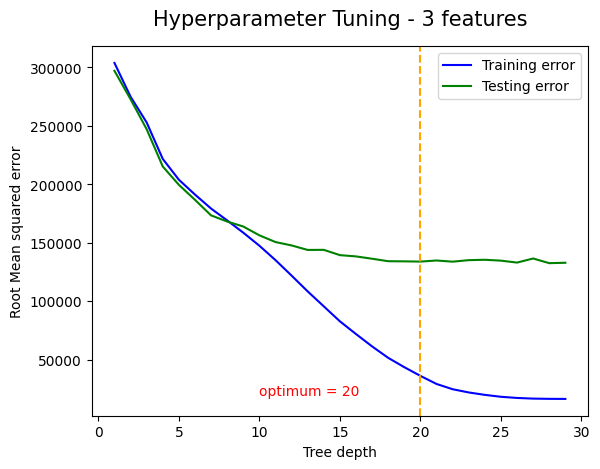

In [ ]:
max_depths = range(1, 30)

training_error = []
for max_depth in max_depths:
    f3_model_1 = DecisionTreeRegressor(max_depth=max_depth)
    f3_model_1.fit(X3, y)
    training_error.append(sqrt(mse(y, f3_model_1.predict(X3))))

testing_error = []
for max_depth in max_depths:
    f3_model_2 = DecisionTreeRegressor(max_depth=max_depth)
    f3_model_2.fit(X_train, y_train)
    testing_error.append(sqrt(mse(y_test, f3_model_2.predict(X_test))))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')
plt.axvline(x=Optimal_3, color='orange', linestyle='--')
plt.annotate('optimum = {}'.format(Optimal_3), xy=(10, 20000), color='red')
plt.ylabel('Root Mean squared error')
plt.title('Hyperparameter Tuning - 3 features', pad=15, size=15)
plt.legend()
plt.savefig('error3.png')

3- Decision Trees for 5 features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size = 0.2, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape = {X_test.shape}')

X_train.shape = (19324, 5)
X_test.shape = (4832, 5)


In [ ]:
def rmse(y_true, y_pred):
    rm = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rm
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
# Make a scorer from the RMSE function
rmse_scorer = (make_scorer(rmse, greater_is_better=False))

model = DecisionTreeRegressor()

gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 25),
                                'min_samples_split': range(5, 50, 5)},
                  cv=kfold,
                  n_jobs=1,
                  scoring=rmse_scorer)

gs.fit(X_train, y_train)

print(gs.best_params_)
print(-gs.best_score_)
Optimal_5 = gs.best_params_['max_depth']
rmse_5 = -gs.best_score_

{'max_depth': 19, 'min_samples_split': 5}
145321.8488721897


*Defining the 5 feature Decision Tree*

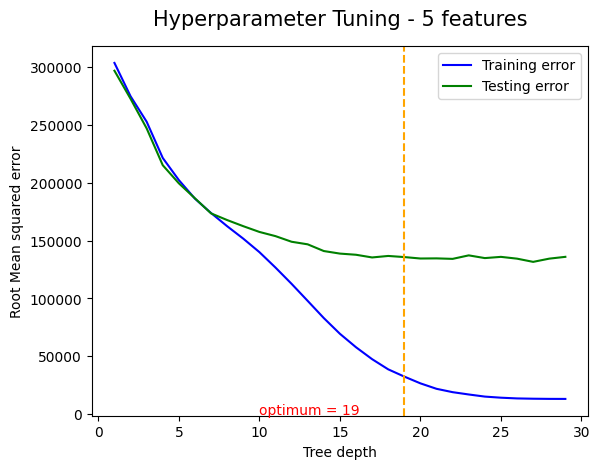

In [ ]:
max_depths = range(1, 30)

training_error = []
for max_depth in max_depths:
    f5_model_1 = DecisionTreeRegressor(max_depth=max_depth)
    f5_model_1.fit(X5, y)
    training_error.append(sqrt(mse(y, f5_model_1.predict(X5))))

testing_error = []
for max_depth in max_depths:
    f5_model_2 = DecisionTreeRegressor(max_depth=max_depth)
    f5_model_2.fit(X_train, y_train)
    testing_error.append(sqrt(mse(y_test, f5_model_2.predict(X_test))))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')
plt.axvline(x=Optimal_5, color='orange', linestyle='--')
plt.annotate('optimum = {}'.format(Optimal_5), xy=(10, 20000), color='red')
plt.ylabel('Root Mean squared error')
plt.title('Hyperparameter Tuning - 5 features', pad=15, size=15)
plt.legend()
plt.savefig('error5.png')

4- Decision Trees for 7 features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X7, y, test_size = 0.2, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape = {X_test.shape}')

X_train.shape = (19324, 7)
X_test.shape = (4832, 7)


In [ ]:
def rmse(y_true, y_pred):
    rm = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rm
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
# Make a scorer from the RMSE function
rmse_scorer = (make_scorer(rmse, greater_is_better=False))

model = DecisionTreeRegressor()

gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 25),
                                'min_samples_split': range(5, 50, 5)},
                  cv=kfold,
                  n_jobs=1,
                  scoring=rmse_scorer)

gs.fit(X_train, y_train)

print(gs.best_params_)
print(-gs.best_score_)
Optimal_7 = gs.best_params_['max_depth']
rmse_7 = -gs.best_score_

{'max_depth': 23, 'min_samples_split': 5}
144256.12395653495


*Defining the 7 feature Decision Tree*

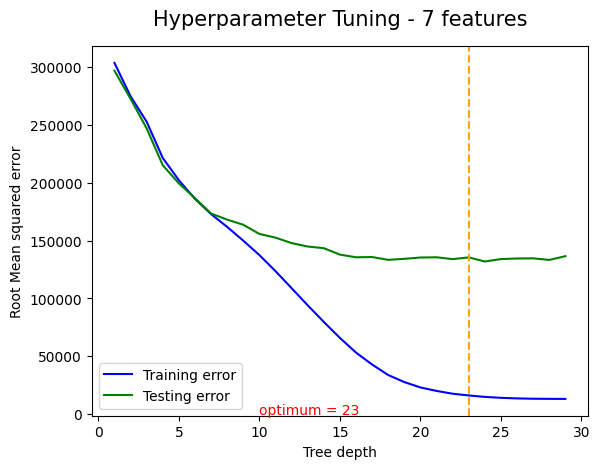

In [ ]:
max_depths = range(1, 30)

training_error = []
for max_depth in max_depths:
    f7_model_1 = DecisionTreeRegressor(max_depth=max_depth)
    f7_model_1.fit(X7, y)
    training_error.append(sqrt(mse(y, f7_model_1.predict(X7))))

testing_error = []
for max_depth in max_depths:
    f7_model_2 = DecisionTreeRegressor(max_depth=max_depth)
    f7_model_2.fit(X_train, y_train)
    testing_error.append(sqrt(mse(y_test, f7_model_2.predict(X_test))))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')
plt.axvline(x=Optimal_7, color='orange', linestyle='--')
plt.annotate('optimum = {}'.format(Optimal_7), xy=(10, 20000), color='red')
plt.ylabel('Root Mean squared error')
plt.title('Hyperparameter Tuning - 7 features', pad=15, size=15)
plt.legend()
plt.savefig('error7.png')

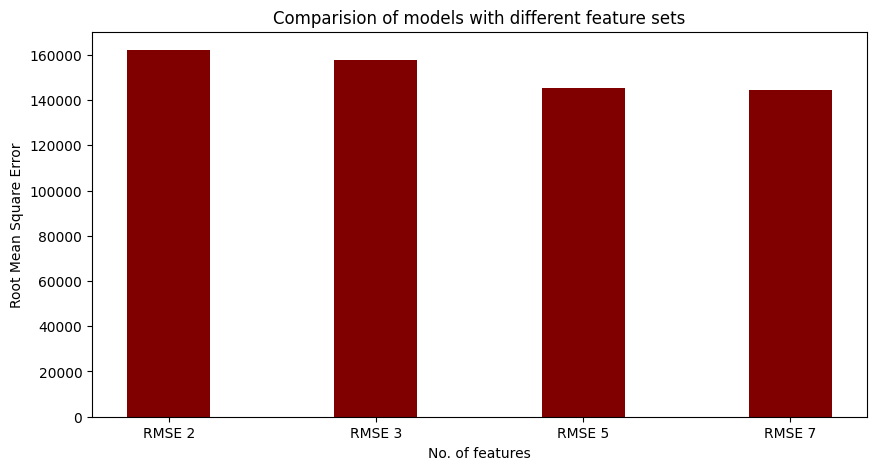

In [ ]:
# creating the dataset
bar = {'RMSE 2': rmse_2, 'RMSE 3': rmse_3, 'RMSE 5': rmse_5, 'RMSE 7': rmse_7}
courses = list(bar.keys())
values = list(bar.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon', width = 0.4)

plt.xlabel("No. of features")
plt.ylabel("Root Mean Square Error")
plt.title("Comparision of models with different feature sets")
plt.show()